# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms , models
from PIL import Image
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [4]:
# Uploading the data set
def imagesuploader (directory='flowers') :
        data_dir=str(directory)
        batchsize= 64
        transforms1 = transforms.Compose([transforms.Resize(250),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()])                          # TODO: compose transforms here
        dataset = datasets.ImageFolder(data_dir, transform=transforms1) # TODO: create the ImageFolder
        dataloader = dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True) # TODO: use the ImageFolder dataset to create the DataLoader
        # Define transforms for the training data and testing data
        #normalization for gray scale is done with ([number],[number]) cause it's 1D

        train_transforms = transforms.Compose([transforms.RandomRotation(80),
                                               transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                  [0.229, 0.224, 0.225])])

        test_transforms = transforms.Compose([ transforms.RandomResizedCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])])

        validation_transforms = transforms.Compose([transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                                         [0.229, 0.224, 0.225])])

        train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms, )
        test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
        validation_data = datasets.ImageFolder(data_dir+'/valid', transform=validation_transforms)


        trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchsize,shuffle=True)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=batchsize,shuffle=True)
        vloader = torch.utils.data.DataLoader(validation_data, batch_size =32,shuffle = True)
    
        return trainloader, testloader, vloader, train_data, test_data, validation_data

Train Loader
Test Loader


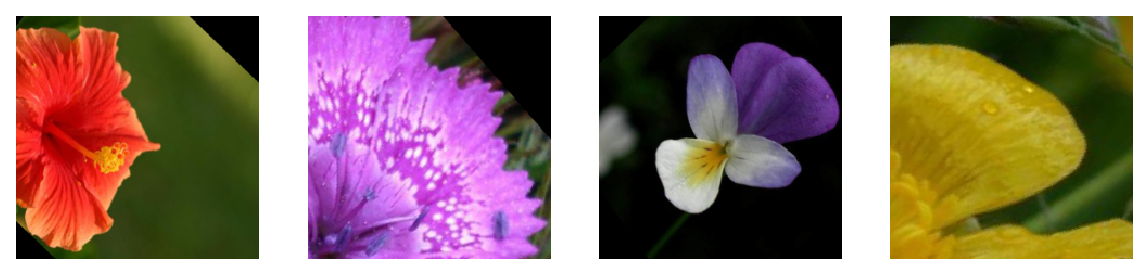

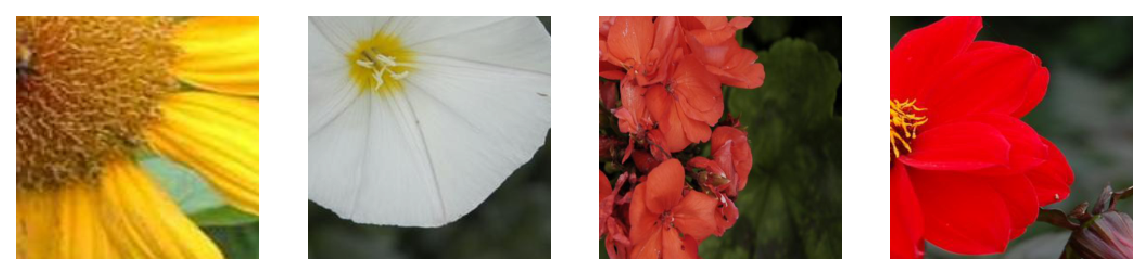

In [5]:
trainloader, testloader, vloader, train_data, test_data, validation_data = imagesuploader()
# change this to the trainloader or testloader 
print("Train Loader")
data_iter = iter(trainloader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax)
    
# change this to the trainloader or testloader 
print("Test Loader")
data_iter = iter(testloader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax)    

In [6]:
# TODO: Build and train your network
def modelbuild( arc=models.densenet121(pretrained=True), firstinputlayer=1024, outputlayer=102, lossf=nn.NLLLoss() , learningrate=0.001, nepoch = 35  ) :

    model = arc
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(firstinputlayer, 512)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(512, outputlayer)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    model.to(device)
    arch=model
    
    return model
#if you wanna change the model enter the full command into arc models. model_name(pretrained=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 97137409.94it/s]


In [7]:
def train(model , lossf=nn.NLLLoss() , learningrate=0.001 , nepoch = 35, print_every= 10 ):
    epochs = nepoch
    # cross entropy loss combines softmax and nn.NLLLoss() in one single class.
    criterion = lossf

    ## TODO: specify optimizer 
    # stochastic gradient descent with a small learning rate and some momentum
    learning_rate= learningrate
    optimizer = optim.SGD(model.classifier.parameters() , lr=learning_rate, momentum=0.9)
    for n_epochs in range(epochs):
        running_loss = 0
        steps = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs,labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                vlost = 0
                accuracy=0


                for ii, (inputs2,labels2) in enumerate(vloader):
                    optimizer.zero_grad()

                    inputs2, labels2 = inputs2.to(device) , labels2.to(device)
                    model.to(device)
                    with torch.no_grad():    
                        outputs = model.forward(inputs2)
                        vlost = criterion(outputs,labels2)
                        ps = torch.exp(outputs).data
                        equality = (labels2.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean()

                vlost = vlost / len(vloader)
                accuracy = accuracy /len(vloader)



                print("Epoch: {}/{}... ".format(n_epochs+1, epochs),
                      "Loss: {:.4f}... ".format(running_loss/print_every),
                      "Validation Lost {:.4f}... ".format(vlost),
                       "Accuracy: {:.4f}... ".format(accuracy))


                running_loss = 0
    return 

In [8]:
# to create the model
model=modelbuild()

In [62]:
# to train the model
train(model, nepoch=1)
print('train finished')

Epoch: 1/1...  Loss: 4.6501...  Validation Lost 0.1776...  Accuracy: 0.0108... 
Epoch: 1/1...  Loss: 4.6121...  Validation Lost 0.1752...  Accuracy: 0.0312... 
Epoch: 1/1...  Loss: 4.6005...  Validation Lost 0.1756...  Accuracy: 0.0562... 
Epoch: 1/1...  Loss: 4.5677...  Validation Lost 0.1774...  Accuracy: 0.0541... 
Epoch: 1/1...  Loss: 4.5190...  Validation Lost 0.1708...  Accuracy: 0.0526... 
Epoch: 1/1...  Loss: 4.5105...  Validation Lost 0.1720...  Accuracy: 0.0622... 
Epoch: 1/1...  Loss: 4.4624...  Validation Lost 0.1709...  Accuracy: 0.0776... 
Epoch: 1/1...  Loss: 4.4171...  Validation Lost 0.1685...  Accuracy: 0.0853... 
Epoch: 1/1...  Loss: 4.4250...  Validation Lost 0.1652...  Accuracy: 0.0860... 
Epoch: 1/1...  Loss: 4.3902...  Validation Lost 0.1629...  Accuracy: 0.0884... 
train finished


In [14]:
# Test out your network!
model.eval()
correct = 0
total = 0
model.to(device)
with torch.no_grad():
     for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 84 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [66]:
#to save the model
torch.save(model.state_dict(),'checkpoint.path')

In [9]:
# load the net parameters by name
model.load_state_dict(torch.load('checkpoint.path',map_location=lambda storage, loc: storage))


In [65]:
# Test out your network!
model.eval()
correct = 0
total = 0
model.to(device)
with torch.no_grad():
     for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 84 %


In [75]:
#model.class_to_idx =train_data.class_to_idx

#classtoindex = model.class_to_idx
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [56]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    image= Image.open(image)
   
    testtransform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]) ])
    image=testtransform(image)
    
    return image



#add = ('flowers'+'/test' + '/1/' + 'image_06752.jpg')
#image = process_image(add)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

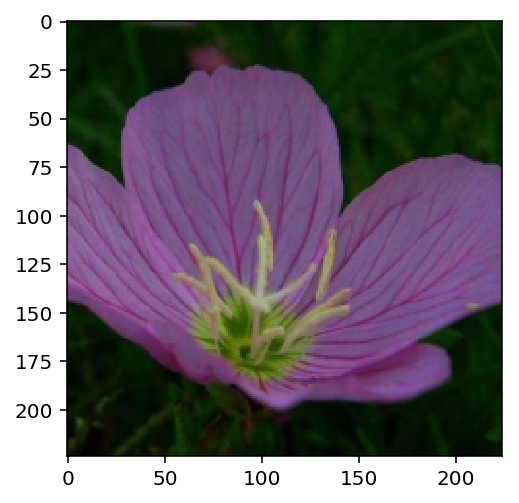

In [57]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
image=process_image(('flowers'+'/test' + '/1/' + 'image_06752.jpg'))
x=imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

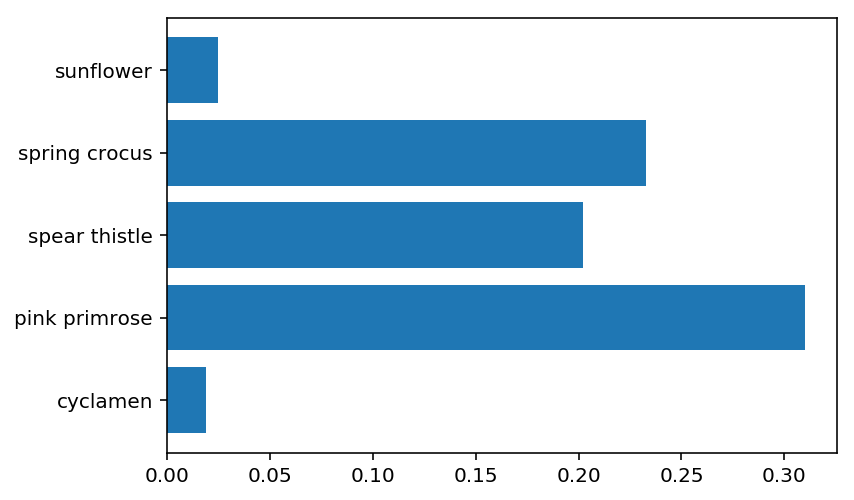

In [217]:
def predict(image_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # to create the model
    model=modelbuild()
    # load the net parameters by name
    model.load_state_dict(torch.load('checkpoint.path',map_location=lambda storage, loc: storage))
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    model.to(device)
    image=process_image(image_path)
    image= image.unsqueeze(0)
    image = image.float()
    output=model(image)
    output=F.softmax(output.data ,dim=1)
    k=torch.topk(output,topk)
    prob= np.array(k[0][0])
    name = [cat_to_name[str(index + 1)] for index in np.array(k[1][0])]
    
    plt.barh(y=name, width=prob)
    
    return k, prob, name
k, probability, name=predict('flowers/test/1/image_06752.jpg')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.